#TASK 1

In [ ]:
#imports
import numpy as np
import random
import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

The code below is for making the board. I will have -2 represent mine cells, and values 0-8 representing safe cells and their corresponding clues.

In [ ]:
#initialize board

def make_board(height, width, mines):
  grid = np.zeros((height, width), dtype=int)

  mine_positions = set()

  while len(mine_positions) < mines:
    new_mine = (np.random.randint(0, height), np.random.randint(0, width))
    mine_positions.add(new_mine)

  for mine in mine_positions:
    grid[mine] = -2
    for x in range(max(mine[0]-1, 0), min(mine[0]+2, height)):
      for y in range(max(mine[1]-1, 0), min(mine[1]+2, width)):
        if grid[x, y] != -2:
          grid[x, y] += 1

  return grid


In [ ]:
easy_board = make_board(9, 9, 10)
medium_board = make_board(16, 16, 40)
hard_board = make_board(30, 16, 99)

print(easy_board)

print(medium_board)

print(hard_board)

[[ 2 -2  3  2 -2  1  0  0  0]
 [ 3 -2  3 -2  2  1  0  0  0]
 [-2  2  2  1  1  1  1  2  1]
 [ 2  3  2  1  0  1 -2  2 -2]
 [ 2 -2 -2  1  0  1  1  2  1]
 [-2  3  2  1  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]]
[[ 1  1  0  0  0  0  0  0  1  1  1  0  0  0  0  0]
 [-2  1  0  0  0  0  1  1  3 -2  2  0  0  0  0  0]
 [ 1  1  0  0  0  0  1 -2  3 -2  2  1  1  1  1  1]
 [ 0  0  0  0  0  0  1  1  3  2  2  1 -2  1  1 -2]
 [ 0  0  0  0  0  0  0  1  3 -2  4  4  3  2  2  2]
 [ 0  0  1  1  1  0  0  1 -2 -2 -2 -2 -2  1  2 -2]
 [ 0  0  2 -2  2  0  1  2  3  3  4  4  3  1  2 -2]
 [ 0  1  3 -2  2  0  1 -2  1  0  1 -2  1  0  1  1]
 [ 0  1 -2  2  1  0  1  1  1  0  1  1  2  1  1  0]
 [ 0  1  1  1  0  0  0  1  1  1  1  1  2 -2  1  0]
 [ 0  0  0  0  0  0  0  1 -2  1  1 -2  2  1  1  0]
 [ 1  1  0  0  1  1  1  1  1  1  1  1  1  0  1  1]
 [-2  1  0  1  3 -2  3  1  1  0  1  2  2  1  1 -2]
 [ 1  2  2  3 -2 -2  4 -2  2  1  1 -2 -2  3  3  2]
 [ 0  1 -2 -2  

The code below is for the logic bot. The logic bot follows the pseudocode steps from the assignment writeup.

In [ ]:
#get neighbors of a cell in a row
def get_neighbors(row, col, height, width):
    neighbors = []
    for i in range(max(0, row - 1), min(row + 2, height)):
      for j in range(max(0, col - 1), min(col + 2, width)):
        if i != row or j != col:
          neighbors.append((i, j))
    return neighbors

In [ ]:
#initialize the playing board- this will be updated as the game states for model training
def init_game_board(height, width):
  board = torch.full((height, width), -1)
  return board

In [ ]:

#new logic bot
def play_logic_bot(board, height, width):
  cells_remaining = set((x, y) for x in range(height) for y in range(width))
  inferred_safe = set()
  inferred_mine = set()
  clue_number = {}

  #arrays to store game states and target values in
  game_states = []
  targets = []

  #get initial game board with all unrevealed cells
  playing_board = init_game_board(height, width)

  game_won = True

  iteration = 0

  while cells_remaining:
    #get the first cell
    if iteration == 0:
      cell = random.choice([t for t in cells_remaining if board[t[0]][t[1]] != -2])
    #get the cell
    if inferred_safe:
      cell = inferred_safe.pop()
    else:
      cell = random.choice(list(cells_remaining))
    x, y = cell

    #update iteration
    iteration += 1

    #update game board and add to game states array. add actual board to target array
    playing_board[x, y] = board[x][y]
    game_states.append(playing_board)
    targets.append(torch.from_numpy(board))


    #if cell is mine, end game and return its lost
    if board[x][y] == -2:
      game_won = False
      break

    #update clue number dict
    clue_number[(x, y)] = board[x][y]

    #get neighbors of the cell
    neighbors_list = get_neighbors(x, y, height, width)

    #if clue is 0 (no surrounding mines), put the cell's neighbors in inferred safe
    if board[x][y] == 0:
      inferred_safe.update(neighbors_list)

    #if clue is greater than 0, do stuff to update inferred mines
    for neighbor in neighbors_list:
      neighbor_row, neighbor_col = neighbor

      #if neighbor is in cells remaining and is a mine, put in inferred mines
      if neighbor in cells_remaining and board[neighbor_row][neighbor_col] == -2:
        inferred_mine.add(neighbor)

      surrounding_mines = sum(1 for n in get_neighbors(neighbor_row, neighbor_col, height, width) if n in inferred_mine)
      unrevealed_neighbors = [n for n in get_neighbors(neighbor_row, neighbor_col, height, width) if n in cells_remaining]

      if board[neighbor_row][neighbor_col] == surrounding_mines:
        inferred_safe.update(unrevealed_neighbors)
        cells_remaining.difference_update(unrevealed_neighbors)
      elif board[neighbor_row, neighbor_col] - surrounding_mines == len(unrevealed_neighbors):
        inferred_mine.update(unrevealed_neighbors)
        cells_remaining.difference_update(unrevealed_neighbors)

  #return game_won, array of game states, and array of target values
  return game_won, game_states, targets, iteration



In [ ]:
#test out logic bot on 100 easy boards
height = 9
width = 9
num_mines = 10
wins = 0

for _ in range(100):
  board = make_board(height, width, num_mines)
  #print(board)
  result, game_states, targets, iteration = play_logic_bot(board, height, width)
  if result:
    wins += 1
print(wins)


6


We can see that our logic bot is able to function properly. Now let's generate data for training. I will do this by using the logic bot to play lots of games. The logic bot will save each game state, which will be used for our X training data, while the Y training data is just the true board of 0s and 1s of where the mines are. I will have 0s represent safe cells and 1s represent mine cells.

I will generate 100 easy boards, 100 intermediate boards, and 100 expert boards. I will then have the logic bot play each level of difficulty and save the game states and its target values. For each level, there will be a training set of data for the model to learn from.

In [ ]:
#easy board data
easy_game_states = []
easy_targets = []
for _ in range(1000):
  board = make_board(9, 9, 10)
  result, game_states, targets, iteration = play_logic_bot(board, 9, 9)
  easy_game_states.extend(game_states)
  easy_targets.extend(targets)

easy_game_states_tensor = torch.stack(easy_game_states)
easy_targets_tensor = torch.stack(easy_targets)

easy_dataset = TensorDataset(easy_game_states_tensor, easy_targets_tensor)
easy_train_loader = DataLoader(easy_dataset, batch_size=64, shuffle=True)

#intermediate board data
med_game_states = []
med_targets = []
for _ in range(100):
  board = make_board(16, 16, 40)
  result, game_states, targets, iteration = play_logic_bot(board, 16, 16)
  med_game_states.extend(game_states)
  med_targets.extend(targets)

med_game_states_tensor = torch.stack(med_game_states)
med_targets_tensor = torch.stack(med_targets)

med_dataset = TensorDataset(med_game_states_tensor, med_targets_tensor)
med_train_loader = DataLoader(med_dataset, batch_size=64, shuffle=True)

#expert board data
hard_game_states = []
hard_targets = []
for _ in range(100):
  board = make_board(30, 16, 99)
  result, game_states, targets, iteration = play_logic_bot(board, 30, 16)
  hard_game_states.extend(game_states)
  hard_targets.extend(targets)

hard_game_states_tensor = torch.stack(hard_game_states)
hard_targets_tensor = torch.stack(hard_targets)

hard_dataset = TensorDataset(hard_game_states_tensor, hard_targets_tensor)
hard_train_loader = DataLoader(hard_dataset, batch_size=64, shuffle=True)

Now that I have saved the data for each difficulty level into data loaders, I can build the model. I use a 2-dimensional CNN model that has 3 CNN layers and 3 batch norm layers. Inputs for the model are game states, meaning that they are game boards that have a subset of cells revealed. The output will be what the predicted "true" board is in terms of probabilities for each cell on whether it is a mine or not.

The architecture of the CNN model I developed starts with an embedding layer that maps the input board due to the fact that each cell has 11 possible states, so the embedding matrix should have 11 representational vectors that can be learned. The model also has 3 2d convolutional layers, which will apply spatial filters to extract the relevant features from the board. Each convolutional layer is followed by batch normalization, which helps to stabilize the training process. I wanted to build a network that could be applicable to the easy, intermediate, and expert level boards in terms of size, so I also added an adaptive average pooling layer.



In [ ]:
class CNNModel(nn.Module):
    def __init__(self, height, width):
      super(CNNModel, self).__init__()

      self.height = height
      self.width = width

      self.embedding = nn.Embedding(11, 10)

      self.conv1 = nn.Conv2d(10, 16, kernel_size=3, padding=1)
      self.batch1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
      self.batch2 = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.batch3 = nn.BatchNorm2d(64)

      self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))   #to account for varying minesweeper board sizes

      self.output_layer = nn.Linear(64 * 4 * 4, height * width)

    def forward(self, input_tensor):

      input_tensor = input_tensor.long()
      input_tensor = input_tensor + 2

      #print(input_tensor)

      output = self.embedding(input_tensor)

      if len(output.size()) != 4:
        output.unsqueeze(0).permute(0,3,1,2)
        #output.unsqueeze(0)
      else:
        output = output.permute(0, 3, 1, 2)

      #print(output.size())

      output = self.conv1(output)
      output = self.batch1(output)
      output = self.conv2(output)
      output = self.batch2(output)
      output = self.conv3(output)
      output = self.batch3(output)

      output = self.adaptive_pool(output)

      output = output.reshape(output.size(0), -1) #have to do some sort of reshaping after batch
      output = self.output_layer(output)
      output = torch.nn.functional.softmax(output, dim=1) #maybe do (dim=1)(output)
      return output

def train_easy_games(train_loader, model, num_epochs=10):
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_loss = []

  for epoch in range(num_epochs):
    total_loss = 0

    for game_states, targets in train_loader:
      optimizer.zero_grad()
      outputs = model(game_states)

      # outputs.unsqueeze(0)
      # print(outputs.size())
      # print("outputs", outputs)

      # print(targets.size())
      # print(targets)

      targets = targets.view(targets.size(0), -1)

      loss = loss_fn(outputs, targets.float())  #may have to change this

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      train_loss.append(loss)

    print("loss at epoch", train_loss[-1])




Below I am training the models for easy, intermediate, and expert levels.

In [ ]:
easy_height = 9
easy_width = 9
easy_model = CNNModel(easy_height, easy_width)
train_easy_games(easy_train_loader, easy_model, num_epochs=10)

loss at epoch tensor(1.6778, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6562, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6655, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6763, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6663, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6565, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6676, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6293, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6490, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.6784, grad_fn=<MseLossBackward0>)


In [ ]:
med_height = 16
med_width = 16
med_model = CNNModel(med_height, med_width)
train_easy_games(med_train_loader, med_model, num_epochs=10)

loss at epoch tensor(2.4842, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5083, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5621, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5102, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5603, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.4787, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5473, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5527, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5167, grad_fn=<MseLossBackward0>)
loss at epoch tensor(2.5072, grad_fn=<MseLossBackward0>)


In [ ]:
hard_height = 30
hard_width = 16
hard_model = CNNModel(hard_height, hard_width)
train_easy_games(hard_train_loader, hard_model, num_epochs=10)

loss at epoch tensor(3.6750, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6640, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6782, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.7035, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6806, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6704, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6717, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6929, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6872, grad_fn=<MseLossBackward0>)
loss at epoch tensor(3.6642, grad_fn=<MseLossBackward0>)


The code below is for the network bot playing the game. The game is played as follows: We have an initial playing board that has all cells unclicked. The agent will first choose a random cell from the board to unclick at the start of the game. Then, we see if the cell is a mine or not. If it is a mine, then the game ends. If it is not a mine, then the playing board is updated with the clue value of the cell. For following iterations, the trained CNN model will output the probabilities that each cell is a mine, with the highest probabilities meaning that the cell is more likely to be a mine and the lowest probabilities meaning that the cell is more likely to be safe. From there, the agent looks at the probabilities of the remaining cells of our playing board and chooses the cell with the lowest probability to click on. We also keep track of how many cells are clicked and check that with the total amount of safe cells in the board, so that if those two values are equal, then the agent has won the game and cleared the board.

In [ ]:
def network_bot_play(model, board, height, width):
  playing_board = init_game_board(height, width)
  playing_board = playing_board.unsqueeze(0)
  cells_remaining = set((x, y) for x in range(height) for y in range(width))
  cells_clicked = 0
  num_nonmine_cells = 1 - np.count_nonzero(board)


  steps = 1

  game_won = True

  while 1:
    if steps == 0:
      cell = random.choice(list(cells_remaining))
      x, y = cell
    else:
      probs = model(playing_board)
      probs_matrix = probs.view(height, width)

      #get prediction and cell based on prediction- do this by getting tuple w lowest prob in cells_remaining
      probs_np = probs_matrix.detach().numpy()
      #print(probs_np)

      min_value = np.inf
      min_coords = None

      for coords in cells_remaining:
        x, y = coords
        value = probs_np[x, y]

        if value < min_value:
          min_value = value
          min_coords = coords

      x,y = min_coords
      #print((x,y))

    cells_remaining.remove((x,y))
    cells_clicked += 1


    #update playing board
    if board[x][y] == -2:   #clicked cell is mine
      game_won = False
      break

    playing_board[0, x, y] = board[x][y]   #clicked cell is not mine- update board

    #see if all safe cells have been clicked- if so- game won!
    if cells_clicked == num_nonmine_cells:
      break

    steps += 1

  return game_won, steps


In [ ]:
test_board = make_board(9, 9, 10)
network_bot_play(easy_model, test_board, 9, 9)

(False, 2)

##Easy Boards: Logic Bot vs. Network Bot

I will now compare the performances of the logic bot and the network bot on easy boards. I will do this by having both bots play the same set of 100 boards and gather results. I will gather the number of games both bots won and the amount of steps both bots took before they reached a mine or reached the end of the game.

In [ ]:
test_easy_boards = []
for _ in range(100):
  board = make_board(9,9,10)
  test_easy_boards.append(board)

logic_games_won = 0
logic_steps = 0

nn_games_won = 0
nn_steps = 0

for board in test_easy_boards:
  logic_game_won, _, _, logic_step = play_logic_bot(board, 9, 9)
  nn_game_won, nn_step = network_bot_play(easy_model, board, 9, 9)

  if logic_game_won:
    logic_games_won += 1
  if nn_game_won:
    nn_games_won += 1

  logic_steps += logic_step
  nn_steps += nn_step

print("logic bot games won: ", logic_games_won)
print("logic bot avg survived steps: ", logic_steps/100)

print("CNN bot games won: ", nn_games_won)
print("CNN bot avg survived steps: ", nn_steps/100)




logic bot games won:  9
logic bot avg survived steps:  15.12
CNN bot games won:  0
CNN bot avg survived steps:  6.66


Now I will compare the performances of the logic bot and network bot on intermediate boards.

In [ ]:
test_med_boards = []
for _ in range(100):
  board = make_board(16,16,40)
  test_med_boards.append(board)

logic_games_won = 0
logic_steps = 0

nn_games_won = 0
nn_steps = 0

for board in test_med_boards:
  logic_game_won, _, _, logic_step = play_logic_bot(board, 16, 16)
  nn_game_won, nn_step = network_bot_play(med_model, board, 16, 16)

  if logic_game_won:
    logic_games_won += 1
  if nn_game_won:
    nn_games_won += 1

  logic_steps += logic_step
  nn_steps += nn_step

print("logic bot games won: ", logic_games_won)
print("logic bot avg survived steps: ", logic_steps/100)

print("CNN bot games won: ", nn_games_won)
print("CNN bot avg survived steps: ", nn_steps/100)

logic bot games won:  0
logic bot avg survived steps:  13.56
CNN bot games won:  0
CNN bot avg survived steps:  6.89


Now I will compare the performances of the logic bot and network bot on expert boards.

In [ ]:
test_hard_boards = []
for _ in range(100):
  board = make_board(30,16,99)
  test_hard_boards.append(board)

logic_games_won = 0
logic_steps = 0

nn_games_won = 0
nn_steps = 0

for board in test_hard_boards:
  logic_game_won, _, _, logic_step = play_logic_bot(board, 30, 16)
  nn_game_won, nn_step = network_bot_play(hard_model, board, 30, 16)

  if logic_game_won:
    logic_games_won += 1
  if nn_game_won:
    nn_games_won += 1

  logic_steps += logic_step
  nn_steps += nn_step

print("logic bot games won: ", logic_games_won)
print("logic bot avg survived steps: ", logic_steps/100)

print("CNN bot games won: ", nn_games_won)
print("CNN bot avg survived steps: ", nn_steps/100)

logic bot games won:  0
logic bot avg survived steps:  8.97
CNN bot games won:  0
CNN bot avg survived steps:  5.29




#Task 1 Analysis

As you can see from the results above, the model did not have good losses when trained on the data for easy, intermediate, and expert level boards. I believe this has to do with my training data generation. I think that because the logic bot that I created based on the pseudocode given in the writeup was not able to win many games (usually 8/9 games won on easy boards out of 100 games), the models were not able to perform well either. For each board level training, the loss stayed generally the same. For comparing the performance of the logic bot with the network, I used number of games won and average steps taken before hitting a mine. Both of my bots did not continue playing the game after a they hit a mine, so I did not use average number of mines hit before game ends as a metric. As you can see above, the logic bot performs better than my network bot in all difficulty levels, but are closer in performance for the expert board.

#TASK 2

In task 2, I have to get the model to have good results on boards of size 30x30 where the number of mines ranges from 0% to 30% of the board. From task 1, a few things have to change to adjust to these parameters. The biggest change to adjust to variable mines is to have the model be trained on data where we have boards of size 30x30 with variable numbers of mines. Previously, the models were trained separately for easy, intermediate, and expert boards where each type of board had a set number of mines and each model was only fit for its corresponding difficulty. Now, I will generate data for 30x30 boards that have 0% to 30% of the board covered in mines and I will train a model on that data. I will then compare the performance of the trained model and the logic bot on 100 boards and compare.

In [ ]:
mine_height = 30
mine_width = 30
mine_game_states = []
mine_targets = []
for _ in range(100):
  num_mines = random.randint(0, 270)
  board = make_board(mine_height, mine_width, num_mines)
  result, game_states, targets, iteration = play_logic_bot(board, mine_height, mine_width)
  mine_game_states.extend(game_states)
  mine_targets.extend(targets)

mine_game_states_tensor = torch.stack(mine_game_states)
mine_targets_tensor = torch.stack(mine_targets)

mine_dataset = TensorDataset(mine_game_states_tensor, mine_targets_tensor)
mine_train_loader = DataLoader(mine_dataset, batch_size=64, shuffle=True)

Here, I will adjust the current model architecture to perform better on boards with varying mines. I did not change the model too much, I just added another convolutional layer to have an extra layer and more indepth processing.




In [ ]:
class MineCNNModel(nn.Module):
    def __init__(self, height, width):
      super(MineCNNModel, self).__init__()

      self.height = height
      self.width = width

      self.embedding = nn.Embedding(11, 10)

      self.conv1 = nn.Conv2d(10, 16, kernel_size=3, padding=1)
      self.batch1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
      self.batch2 = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.batch3 = nn.BatchNorm2d(64)
      self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.batch4 = nn.BatchNorm2d(128)

      self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))   #to account for varying minesweeper board sizes

      self.output_layer = nn.Linear(128 * 4 * 4, height * width)

    def forward(self, input_tensor):

      input_tensor = input_tensor.long()
      input_tensor = input_tensor + 2

      #print(input_tensor)

      output = self.embedding(input_tensor)

      if len(output.size()) != 4:
        output.unsqueeze(0).permute(0,3,1,2)
        #output.unsqueeze(0)
      else:
        output = output.permute(0, 3, 1, 2)

      #print(output.size())

      output = self.conv1(output)
      output = self.batch1(output)
      output = self.conv2(output)
      output = self.batch2(output)
      output = self.conv3(output)
      output = self.batch3(output)
      output = self.conv4(output)
      output = self.batch4(output)

      output = self.adaptive_pool(output)

      output = output.reshape(output.size(0), -1) #have to do some sort of reshaping after batch
      output = self.output_layer(output)
      output = torch.nn.functional.softmax(output, dim=1) #maybe do (dim=1)(output)
      return output

def train_mine_games(train_loader, model, num_epochs=10):
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_loss = []

  for epoch in range(num_epochs):
    total_loss = 0

    for game_states, targets in train_loader:
      optimizer.zero_grad()
      outputs = model(game_states)

      # outputs.unsqueeze(0)
      # print(outputs.size())
      # print("outputs", outputs)

      # print(targets.size())
      # print(targets)

      targets = targets.view(targets.size(0), -1)

      loss = loss_fn(outputs, targets.float())  #may have to change this

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      train_loss.append(loss)

    print("loss at epoch", train_loss[-1])

In [ ]:
mine_model = MineCNNModel(mine_height, mine_width)
train_mine_games(mine_train_loader, mine_model, num_epochs=10)

loss at epoch tensor(0.7591, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.7389, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.6996, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.9108, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.8296, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.8681, grad_fn=<MseLossBackward0>)
loss at epoch tensor(1.2683, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.9698, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.9768, grad_fn=<MseLossBackward0>)
loss at epoch tensor(0.7451, grad_fn=<MseLossBackward0>)


Now that the model is trained, I will compare the performance of the logic bot and the trained network bot.

In [ ]:
#DICTS FOR PLOTTING
logic_won_dict = {}
nn_won_dict = {}

logic_steps_dict = {}
nn_steps_dict = {}

mine_height = 30
mine_width = 30

test_mine_boards = []
for _ in range(100):
  num_mines = random.randint(0, 270)
  board = make_board(mine_height, mine_width, num_mines)
  test_mine_boards.append((board, num_mines))

logic_games_won = 0
logic_steps = 0

nn_games_won = 0
nn_steps = 0

for board, num_mines in test_mine_boards:
  logic_game_won, _, _, logic_step = play_logic_bot(board, mine_height, mine_width)
  nn_game_won, nn_step = network_bot_play(mine_model, board, mine_height, mine_width)

  #saves the amount of logic games won for each amt of mines in the board
  if logic_game_won:
    logic_games_won += 1
    if num_mines not in logic_won_dict:
      logic_won_dict[num_mines] = logic_games_won
    else:
      logic_won_dict[num_mines] += 1
  else:
    if num_mines not in logic_won_dict:
      logic_won_dict[num_mines] = 0

  #saves the amount of nn games won for each amt of mines in the board
  if nn_game_won:
    nn_games_won += 1
    if num_mines not in nn_won_dict:
      nn_won_dict[num_mines] = nn_games_won
    else:
      nn_won_dict[num_mines] += 1
  else:
    if num_mines not in nn_won_dict:
      nn_won_dict[num_mines] = 0

  #saves the amount of steps the logic bot takes for each amt of mines in the board
  logic_steps += logic_step
  if num_mines not in logic_steps_dict:
    logic_steps_dict[num_mines] = [logic_steps]
  else:
    logic_steps_dict[num_mines].append(logic_step)

  #saves the amount of steps the nn bot takes for each amt of mines in the board
  nn_steps += nn_step
  if num_mines not in nn_steps_dict:
    nn_steps_dict[num_mines] = [nn_steps]
  else:
    nn_steps_dict[num_mines].append(nn_step)


print("logic bot games won: ", logic_games_won)
print("logic bot avg survived steps: ", logic_steps/100)
print("logic wins dict: ", logic_won_dict)
print("logic steps dict: ", logic_steps_dict)

print("CNN bot games won: ", nn_games_won)
print("CNN bot avg survived steps: ", nn_steps/100)
print("CNN bot wins dict: ", nn_won_dict)
print("CNN bot steps dict: ", nn_steps_dict)

logic bot games won:  2
logic bot avg survived steps:  77.37
logic wins dict:  {182: 0, 60: 0, 179: 0, 49: 0, 84: 0, 173: 0, 95: 0, 154: 0, 24: 0, 96: 0, 175: 0, 91: 0, 17: 0, 40: 0, 120: 0, 178: 0, 76: 0, 36: 0, 138: 0, 142: 0, 129: 0, 206: 0, 209: 0, 20: 0, 10: 0, 257: 0, 41: 0, 90: 0, 188: 0, 111: 0, 21: 0, 130: 0, 181: 0, 165: 0, 87: 0, 210: 0, 191: 0, 65: 0, 135: 0, 215: 0, 159: 0, 106: 0, 186: 0, 16: 0, 70: 0, 94: 0, 234: 0, 0: 1, 237: 0, 225: 0, 174: 0, 131: 0, 33: 0, 143: 0, 19: 0, 119: 0, 98: 0, 100: 0, 228: 0, 196: 0, 15: 0, 180: 0, 169: 0, 56: 0, 168: 0, 1: 2, 260: 0, 81: 0, 252: 0, 58: 0, 46: 0, 66: 0, 199: 0, 194: 0, 50: 0, 163: 0, 202: 0, 147: 0, 193: 0, 259: 0, 104: 0, 242: 0, 2: 0, 152: 0, 92: 0, 170: 0}
logic steps dict:  {182: [4, 2], 60: [93, 13], 179: [96], 49: [113], 84: [120], 173: [124], 95: [132, 13], 154: [137], 24: [322, 54], 96: [355], 175: [369], 91: [370], 17: [556], 40: [579], 120: [583], 178: [589], 76: [599, 20], 36: [695], 138: [703], 142: [712], 129: [

Below is the code for plotting the probability of clearing the board over number of mines and the average steps taken before hitting a mine over number of mines for both the logic bot and the network bot.

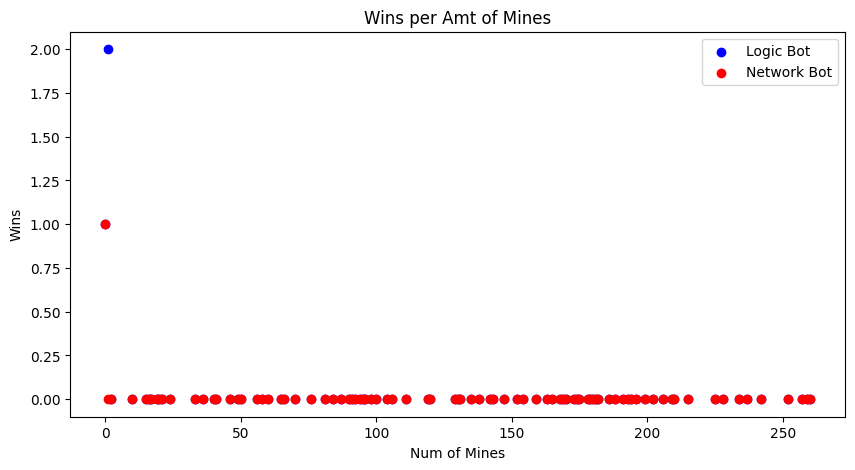

In [ ]:
#plot for logic wins vs bot wins
sorted_logic_wins_data = dict(sorted(logic_won_dict.items()))
sorted_nn_wins_data = dict(sorted(nn_won_dict.items()))

logic_keys = list(sorted_logic_wins_data.keys())
logic_values = list(sorted_logic_wins_data.values())

nn_keys = list(sorted_nn_wins_data.keys())
nn_values = list(sorted_nn_wins_data.values())

plt.figure(figsize=(10, 5))
plt.scatter(logic_keys, logic_values, c='blue', label='Logic Bot')
plt.scatter(nn_keys, nn_values, c='red', label='Network Bot')
plt.xlabel('Num of Mines')
plt.ylabel('Wins')
plt.title('Wins per Amt of Mines')
plt.legend()
plt.show()



Below is the code for the plot for the amount of steps taken for each amount of mines on the board for the logic bot and network bot.

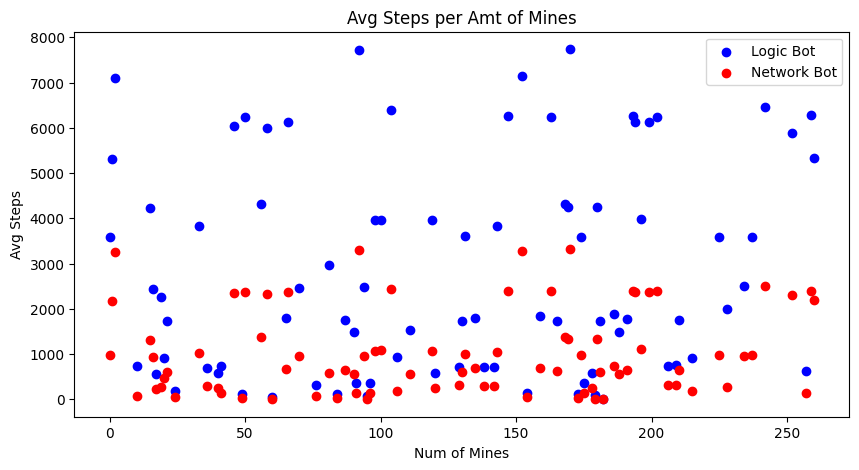

In [ ]:
#plot for logic steps vs bot steps
# sorted_logic_steps_data = dict(sorted(logic_steps_dict.items()))
# sorted_nn_steps_data = dict(sorted(nn_steps_dict.items()))

logic_keys = list(logic_steps_dict.keys())
logic_values = [np.mean(values) for values in logic_steps_dict.values()]

nn_keys = list(nn_steps_dict.keys())
nn_values = [np.mean(values)/len(values) for values in nn_steps_dict.values()]

plt.figure(figsize=(10, 5))
plt.scatter(logic_keys, logic_values, c='blue', label='Logic Bot')
plt.scatter(nn_keys, nn_values, c='red', label='Network Bot')
plt.xlabel('Num of Mines')
plt.ylabel('Avg Steps')
plt.title('Avg Steps per Amt of Mines')
plt.legend()
plt.show()

#Task 2 Analysis

As you can see from the results above, the loss during training decreased slightly, but not that much. The performance for both the logic bot and the network bot was bad, as they both won very small amounts of games out of 100. In terms of average steps before hitting a mine, the plot above shows that the network bot had a lower number of steps taken before hitting a mine compared to the logic bot, which shows the poor performance. I think I can attribute this poor performance to the training data generation and how I used my logic bot to generate data, which may not have been the best approach given the fact that the logic bot did not perform well when playing Minesweeper in general.

#TASK 3

The first step of task 3 is to create data for training the model. Since we want a model that will perform well on boards of varying sizes, I will generate data from the logic bot of game states of varying board sizes.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class VariableSizeDataset(Dataset):
    def __init__(self, game_states, targets, device):
        self.game_states = game_states
        self.targets = targets
        self.device = device

    def __len__(self):
        return len(self.game_states)

    def __getitem__(self, index):
        return self.game_states[index].to(self.device), self.targets[index].to(self.device)

In [ ]:
#generate data

K_game_states = []
K_targets = []
for _ in range(100):
  K = random.randint(5, 50)
  num_cells = K * K
  num_mines = random.randint(int(num_cells*.2), int(num_cells*.5))
  board = make_board(K, K, num_mines)
  #print(board)
  result, game_states, targets, iteration = play_logic_bot(board, K, K)
  K_game_states.extend(game_states)
  K_targets.extend(targets)

K_dataset = VariableSizeDataset(K_game_states, K_targets, device)
K_train_loader = DataLoader(K_dataset, batch_size=1, shuffle=True)

# K_game_states_tensor = torch.stack(K_game_states)
# K_targets_tensor = torch.stack(K_targets)

# K_dataset = TensorDataset(K_game_states_tensor, K_targets_tensor)
# K_train_loader = DataLoader(K_dataset, batch_size=64, shuffle=True)

Below is the model for playing minesweeper on varying board sizes. This network is different from the previous ones, as I implement transformer layers to account for input tensors of varying sizes. The previous models worked best for data where the input tensor was the same size across all data, so this new model adjusts for varying tensor sizes through the use of transformer layers. The network starts with an embedding layer (same as the previous models) that is used for encoding cell states. The embedded representation is then passed through transformer layers (I settled on using 2 layers due to memory usage), which help the model focus on key areas of the inputted game state by using self-attention mechanisms. Then, the tensor is passed through a linear layer that is dynamically created in the forward pass rather than the initial architecture to account for input tensors of varying sizes.

In [ ]:
class K_CNNModel(nn.Module):
    def __init__(self, num_heads=2, num_transformer_layers=1):
      super(K_CNNModel, self).__init__()
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      self.embedding = nn.Embedding(11, 10).to(self.device)
      #self.embedding = nn.Embedding(11, 10)

      self.transformer_layers = nn.ModuleList(
            [nn.TransformerEncoderLayer(d_model=10, nhead=num_heads).to(self.device) for _ in range(num_transformer_layers)]
        )

      #self.transformer_layers = self.transformer_layers.to(self.device)


    def forward(self, input_tensor):
      input_tensor = input_tensor.to(self.device)

      batch_size, height, width = input_tensor.size()
      input_tensor = input_tensor.long() + 2
      output = self.embedding(input_tensor)

      output = output.view(batch_size, -1, 10)  #flatten height and width
      positional_encoding = torch.randn(1, height * width, 10, device=self.device)

      output = output + positional_encoding

      output = output.permute(1, 0, 2)   #(sequence_length, batch_size, embedding_dim)

      for layer in self.transformer_layers:
        output = layer(output)

      output = output.permute(1, 0, 2).contiguous()  #(batch_size, sequence_length, embedding_dim)
      output = output.view(batch_size, -1)  #flatten again

      #create the linear layer based on input_tensor's height and width
      output_layer = nn.Linear(height * width * 10, height * width).to(self.device)
      output = output_layer(output)
      output = torch.nn.functional.softmax(output, dim=1)
      return output


def train_K_games(train_loader, model, num_epochs=10):
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_loss = []

  for epoch in range(num_epochs):
    total_loss = 0

    for game_states, targets in train_loader:
      game_states, targets = game_states.to(model.device), targets.to(model.device)
      optimizer.zero_grad()
      outputs = model(game_states)

      # outputs.unsqueeze(0)
      # print(outputs.size())
      # print("outputs", outputs)

      # print(targets.size())
      # print(targets)

      targets = targets.view(targets.size(0), -1)

      loss = loss_fn(outputs, targets.float())  #may have to change this

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      train_loss.append(loss)

    print("loss at epoch", train_loss[-1])

In [ ]:
K_model = K_CNNModel()
train_K_games(K_train_loader, K_model, num_epochs=10)

OutOfMemoryError: CUDA out of memory. Tried to allocate 120.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 121.06 MiB is free. Process 310463 has 14.63 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 203.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Below is the code for comparing the performance of the logic bot and network bot on boards of varying sizes. I am using the probability of winning games and average number of steps before bot hits a mine as metrics of performance.

In [ ]:
#code for comparing the logic bot and network bot

logic_won_dict = {}
nn_won_dict = {}

logic_steps_dict = {}
nn_steps_dict = {}

# mine_height = 30
# mine_width = 30

test_mine_boards = []
for _ in range(100):
  K = random.randint(5, 50)
  num_cells = K * K
  num_mines = random.randint(num_cells*.2, num_cells)
  board = make_board(K, K, num_mines)
  test_mine_boards.append((board, K))

logic_games_won = 0
logic_steps = 0

nn_games_won = 0
nn_steps = 0

for board, K in test_mine_boards:
  logic_game_won, _, _, logic_step = play_logic_bot(board, mine_height, mine_width)
  nn_game_won, nn_step = network_bot_play(K_model, board, mine_height, mine_width)

  #saves the amount of logic games won for each amt of mines in the board
  if logic_game_won:
    logic_games_won += 1
    if K not in logic_won_dict:
      logic_won_dict[K] = logic_games_won
    else:
      logic_won_dict[K] += 1
  else:
    if K not in logic_won_dict:
      logic_won_dict[K] = 0

  #saves the amount of nn games won for each amt of mines in the board
  if nn_game_won:
    nn_games_won += 1
    if K not in nn_won_dict:
      nn_won_dict[K] = nn_games_won
    else:
      nn_won_dict[K] += 1
  else:
    if K not in nn_won_dict:
      nn_won_dict[K] = 0

  #saves the amount of steps the logic bot takes for each amt of mines in the board
  logic_steps += logic_step
  if K not in logic_steps_dict:
    logic_steps_dict[K] = [logic_steps]
  else:
    logic_steps_dict[K].append(logic_step)

  #saves the amount of steps the nn bot takes for each amt of mines in the board
  nn_steps += nn_step
  if K not in nn_steps_dict:
    nn_steps_dict[K] = [nn_steps]
  else:
    nn_steps_dict[K].append(nn_step)

Below is the code for plotting the performance metrics

In [ ]:
#plot for logic wins vs bot wins
sorted_logic_wins_data = dict(sorted(logic_won_dict.items()))
sorted_nn_wins_data = dict(sorted(nn_won_dict.items()))

logic_keys = list(sorted_logic_wins_data.keys())
logic_values = list(sorted_logic_wins_data.values())

nn_keys = list(sorted_nn_wins_data.keys())
nn_values = list(sorted_nn_wins_data.values())

plt.figure(figsize=(10, 5))
plt.scatter(logic_keys, logic_values, c='blue', label='Logic Bot')
plt.scatter(nn_keys, nn_values, c='red', label='Network Bot')
plt.xlabel('K')
plt.ylabel('Wins')
plt.title('Wins per K')
plt.legend()
plt.show()


In [ ]:
#plot for logic bot avg steps vs network bot avg steps

logic_keys = list(logic_steps_dict.keys())
logic_values = [np.mean(values) for values in logic_steps_dict.values()]

nn_keys = list(nn_steps_dict.keys())
nn_values = [np.mean(values) for values in nn_steps_dict.values()]

plt.figure(figsize=(10, 5))
plt.scatter(logic_keys, logic_values, c='blue', label='Logic Bot')
plt.scatter(nn_keys, nn_values, c='red', label='Network Bot')
plt.xlabel('K')
plt.ylabel('Avg Steps')
plt.title('Avg Steps per K')
plt.legend()
plt.show()

#Analysis and Explanation of Task 3

As you can see above, I was unable to run my CNN for task 3. I ran into issues regarding my network because I was attempting to use transformer layers to have a better model architecture for minesweeper boards of varying sizes. I decided to use transformer layers because of its ability to capture long-range dependencies and adapt to inputs of varied sizes. Transformers are generally used for the understanding of spatial relationships between different parts of the input, which is something that is important for Minesweeper because the location of mines may often depend on cells that are further away. Transformers are also able to naturally handle inputs of varying sizes, which is why utilizing those layers in my model for task 3 was important. Unfortunately, I struggled with training the model, due to the issue with my GPU memory running out of space, so I could not test out the performance of the improved model with the logic bot, but my hope is that my improved model would perform better than the logic bot. This, however, is largely based on how good the training data is, and in my case, my training data was not always the best due to my logic bot not winning many games.


#TASK 4

You could approach the problem of generating good board to play on by building a generative model based on neural networks. You could develop something where the input could be a set board size and the output would be a corresponding Minesweeper board. The neural network would then be trained on boards that previous bots performed well on, which would then result in a neural network model that performs well and plays Minesweeper well. You could evaluate the quality of the generated boards by comparing them to other previous successful boards and look at mine placements as well as the amount of clear cells around the mines to see if the generated boards are of good quality. This would allow us to make sure that the model produces boards that are accurate to what a Minesweeper board would be without making the boards too easy to win.